In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # disable cuda

In [2]:
input_default_json_conf_file='create_dataset.json';

In [3]:
import sys

import numpy as np
import pandas as pd
import os
import tensorflow as tf
import json
from tensorflow.keras.preprocessing.image import load_img

2024-08-06 23:31:40.515434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 23:31:41.224275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-08-06 23:31:42.336059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 23:31:42.407681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 23:31:42.407881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
## Load json conf file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variable globales

In [6]:
## Seed for the random variables
seed_number=0;

## Dataset 
dataset_base_dir     = DATA['dataset_base_dir'];
dataset_labels_file  = DATA['dataset_labels_file'];
dataset_name         = DATA['dataset_name'];

model_type_body = DATA['model_type_body'];
model_type_face = DATA['model_type_face'];
model_type_skel = DATA['model_type_skel'];


label_colname='label';
filename_colname='filename';
#target_labels=['negative','neutro','pain','positive'];

## Output
output_base_dir = DATA['output_base_dir'];


sub_dir='subdir';

enable_minus=False;

ds_filename=str(dataset_labels_file);

##############################################


# If command line

In [7]:
for n in range(len(sys.argv)):
    if   sys.argv[n]=='--dataset-dir':
        dataset_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-file':
        dataset_labels_file=sys.argv[n+1];
        ds_filename=str(dataset_labels_file);
    elif sys.argv[n]=='--dataset-out-file':
        ds_filename=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--model-type-body':
        model_type_body=sys.argv[n+1];
    elif sys.argv[n]=='--model-type-face':
        model_type_face=sys.argv[n+1];
    elif sys.argv[n]=='--model-type-skel':
        model_type_skel=int(sys.argv[n+1]);
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--sub-dir':
        sub_dir=sys.argv[n+1];
    elif sys.argv[n]=='--minus':
        enable_minus=sys.argv[n+1].strip().lower() == "true";        

print('   dataset_base_dir:',dataset_base_dir)
print('dataset_labels_file:',dataset_labels_file)
print('        ds_filename:',ds_filename)
print('       dataset_name:',dataset_name)
print('    model_type_body:',model_type_body)
print('    model_type_face:',model_type_face)
print('    model_type_skel:',model_type_skel)
print('    output_base_dir:',output_base_dir)
print('            sub_dir:',sub_dir)
print('       enable_minus:',enable_minus)



   dataset_base_dir: ../../BER2024-SOURCE
dataset_labels_file: train.csv
       dataset_name: ber2024
    model_type_body: efficientnet_b3
    model_type_face: efficientnet_b3
    model_type_skel: 20
    output_base_dir: output


# Set seed of random variables


In [8]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Loading data of dataset

In [9]:
# Load filenames and labels
train_val_df = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
print(train_val_df)

                                       filename     label
0       person5/negative/frame_count23_cam1.png  negative
1        person3/neutro/frame_count380_cam1.png    neutro
2           person0/pain/frame_count68_cam1.png      pain
3        person4/neutro/frame_count380_cam0.png    neutro
4          person1/pain/frame_count131_cam0.png      pain
...                                         ...       ...
26954  person1/negative/frame_count262_cam2.png  negative
26955     person7/neutro/frame_count20_cam2.png    neutro
26956  person7/positive/frame_count219_cam1.png  positive
26957   person5/negative/frame_count39_cam2.png  negative
26958    person0/neutro/frame_count238_cam0.png    neutro

[26959 rows x 2 columns]


# Creating output directory

In [10]:

output_dir = os.path.join(output_base_dir,
                          dataset_name,
                          sub_dir);

os.makedirs(output_dir,exist_ok = True);

# Create new model

In [11]:
import BodyEmotion4Lib.Classifier as bec
import FaceEmotion4Lib.Classifier as fec
import SkeletonEmotion4Lib.Classifier as sec

import OpenPifPafTools.RoiDetector as opprd


det=opprd.Detector(checkpoint='shufflenetv2k16');

print('\n\nBODY');
cls_body=bec.Emotion4Classifier(model_type=model_type_body);

print('\n\nFACE');
cls_face=fec.FaceEmotion4Classifier(model_type=model_type_face);

print('\n\nSKELETON');
cls_skel=sec.Emotion4Classifier(ncod=model_type_skel);
#res=cls_body.from_img_pil(img_pil);
#res=cls_face.from_img_pil(img_pil);
#print(res);





BODY
Loading architecture efficientnet_b3

        url: https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1
target_size: (300, 300)



2024-08-06 23:31:46.307934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 23:31:46.308159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 23:31:46.308313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loading the weights in: /home/maquina02/anaconda3/lib/python3.8/site-packages/BodyEmotion4Lib/models/model_efficientnet_b3.h5
Loaded the weights in: /home/maquina02/anaconda3/lib/python3.8/site-packages/BodyEmotion4Lib/models/model_efficientnet_b3.h5


FACE
Loaded layer with efficientnet_b3
Loading the weights in: /home/maquina02/anaconda3/lib/python3.8/site-packages/FaceEmotion4Lib/models/model_efficientnet_b3.h5
Loaded the weights in: /home/maquina02/anaconda3/lib/python3.8/site-packages/FaceEmotion4Lib/models/model_efficientnet_b3.h5


SKELETON
Loading the weights in: /home/maquina02/anaconda3/lib/python3.8/site-packages/SkeletonEmotion4Lib/models/model_onlycls_ncod20.h5
Loaded the weights in: /home/maquina02/anaconda3/lib/python3.8/site-packages/SkeletonEmotion4Lib/models/model_onlycls_ncod20.h5


# Creating PIL data images

Processing images:   0%|                              | 0/26959 [00:00<?, ?it/s]2024-08-06 23:32:10.088614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-06 23:32:10.093074: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


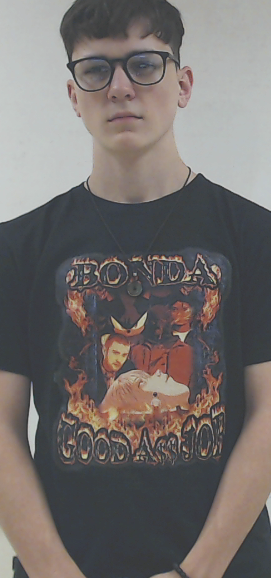

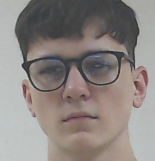

Processing images:   0%|                   | 1/26959 [00:03<26:51:57,  3.59s/it]

[     462.25      209.16     0.99279      485.41      186.72     0.99844      440.02      192.01     0.98979      524.79      208.11     0.99546      417.42      218.46      0.9806      596.79      359.56      0.9806      364.14      369.02     0.96916      614.87      537.02     0.96993      343.12      551.93
     0.95174      541.47      694.88      0.9683      393.95       696.7     0.95092      556.65      700.08     0.67446      406.43      700.98     0.80872           0           0           0           0           0           0           0           0           0           0           0           0]
negative
res_body: [    0.95343    0.046558   9.291e-06  4.2058e-06]
res_face: [    0.93621    0.062831  0.00042541  0.00053459]
res_skel: [     0.4132     0.30083  0.00029412     0.28568]


Processing images:  47%|█████▋      | 12790/26959 [1:46:21<249:49:51, 63.48s/it]

In [ ]:
from tqdm import tqdm
from IPython.display import display
from collections import Counter
import torch
import tensorflow as tf

count=0;
data_list=[];
label_list=[];
H=Counter();
L=len(train_val_df);

#for index, row in tqdm(train_val_df.iterrows(), total=len(train_val_df), desc="Processing images"):
for index, row in train_val_df.iterrows():
    filepath=os.path.join(dataset_base_dir,row[filename_colname]);

    pil_img   = load_img(filepath);
    label_img = row[label_colname].lower();

    skel_vec, body_roi, face_roi=det.process_image(pil_img);

    print(count,'of',L,label_img,filepath);
    
    if skel_vec is not None or body_roi is not None or face_roi is not None:

        H[label_img]+=1;

        res_body=np.array([0.0,0.0,0.0,0.0]);
        res_face=np.array([0.0,0.0,0.0,0.0]);
        if enable_minus == True:
            res_skel=np.zeros(model_type_skel);
        else:
            res_skel=np.zeros(4);

        if body_roi is not None:
            res_body = cls_body.predict_pil(body_roi);
        
        if face_roi is not None:
            res_face = cls_face.predict_pil(face_roi);
        
        if skel_vec is not None:
            if enable_minus == True:
                res_skel = cls_skel.predict_minus_vec(skel_vec);
            else:
                res_skel = cls_skel.predict_vec(skel_vec);

        res = np.concatenate((res_face, res_body, res_skel))

        data_list.append(res);
        label_list.append(label_img);

        #if count == 0:
            #display(body_roi);
            #display(face_roi);
            #print(skel_vec);
            #print(label_img);

            #print('res_body:',res_body)
            #print('res_face:',res_face)
            #print('res_skel:',res_skel)
        
    count = count +1;
    
    if count%200==0:
        torch.cuda.empty_cache();
        tf.keras.backend.clear_session();
 


In [ ]:
print(json.dumps(H, indent=4))

json_filename = os.path.join(output_dir,ds_filename+'.json');
with open(json_filename, "w") as write_file:
    json.dump(H, write_file, indent=4)

In [ ]:
data = [np.append(vector, label) for vector, label in zip(data_list, label_list)]

In [ ]:
import csv

# Especificar o nome do arquivo CSV
csv_filename = os.path.join(output_dir,ds_filename);

# Escrever os dados no arquivo CSV
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['d'+str(x) for x in range(np.size(res_skel)+np.size(res_body)+np.size(res_face))]+['label'])  # Escrever cabeçalhos
    writer.writerows(data)

print(f'Dados salvos em {csv_filename}')